In [1]:
import sys
print(sys.executable)

C:\Users\jyyeo\anaconda3\envs\myenv310\python.exe


In [2]:
import chemgnn

In [3]:
from chemgnn.data import load_csv

import matplotlib.pyplot as plt
import seaborn as sns

from chemgnn.data import load_csv, split_train_test
from chemgnn.datasets.tabular import build_rf_dataset
from chemgnn.models.rf import build_rf
from chemgnn.train.rf_train import (
    cross_validate_rf,
    grid_search_rf,
    train_and_evaluate_rf
)

In [4]:
# 1. raw CSV load
df = load_csv("data_HoC_cyclic_augmented.csv")

# 2. descriptor 계산 + feature/target 분리 (⭐ 핵심 ⭐)
X, y = build_rf_dataset(
    df,
    smiles_col="SMILES",
    target_col="HoC",
)

# 3. split
X_train, X_test, y_train, y_test = split_train_test(
    X, y, test_size=0.2, random_state=41
)

In [5]:
rf = build_rf()
cv_scores = cross_validate_rf(rf, X_train, y_train)
print("CV R2:", cv_scores)

CV R2: [0.90867882 0.84673821 0.94095668 0.28241762 0.77608053]


In [6]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
}

gs = grid_search_rf(build_rf(), param_grid, X_train, y_train)
print("Best params:", gs.best_params_)

Best params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [7]:
best_rf = build_rf(**gs.best_params_)

results = train_and_evaluate_rf(
    best_rf, X_train, y_train, X_test, y_test
)

print(results)

{'r2_train': 0.9779731535837289, 'r2_test': 0.9382904801972622, 'mae_train': 0.44808330909090943, 'mae_test': 1.296025200000001, 'y_train_pred': array([-10.559086 ,  -6.6458136,  -5.139164 ,  -4.584742 ,  -9.314834 ,
       -12.3040564, -11.772622 ,  -9.911098 , -11.769978 ,  -6.5215676,
        -2.693954 , -11.804858 ,  -6.1783368, -12.393342 ,  -8.744932 ,
       -12.709516 ,  -6.159492 ,  -9.321846 , -19.794492 ,  -3.117866 ,
        -9.1081476,  -5.1560028,  -9.8222448,  -2.520782 ,  -3.5962096,
       -17.51898  ,  -6.967498 ,  -7.610842 ,  -4.557928 ,  -3.329554 ,
       -11.3459684,  -4.4962996,  -7.2717836,  -6.5477464,  -5.7077768,
        -3.907286 ,  -5.571868 ,  -8.038014 ,  -4.9957856,  -2.504206 ,
       -15.31803  , -19.070522 , -16.025842 ,  -3.9572808]), 'y_test_pred': array([ -5.2685364, -14.146584 , -16.839052 ,  -6.8010424, -17.029794 ,
        -4.9383148,  -2.86195  ,  -2.672688 , -17.51899  , -12.2181008,
       -13.425004 ])}


In [8]:
from chemgnn.evaluate import regression_metrics

train_pred = results["y_train_pred"]
test_pred  = results["y_test_pred"]

metrics_train = regression_metrics(y_train, train_pred)
metrics_test  = regression_metrics(y_test, test_pred)

print(metrics_train)
print(metrics_test)


{'MAE': 0.44808330909090943, 'RMSE': 0.7191415452500176, 'R2': 0.9779731535837289}
{'MAE': 1.296025200000001, 'RMSE': 1.7200273453867077, 'R2': 0.9382904801972622}


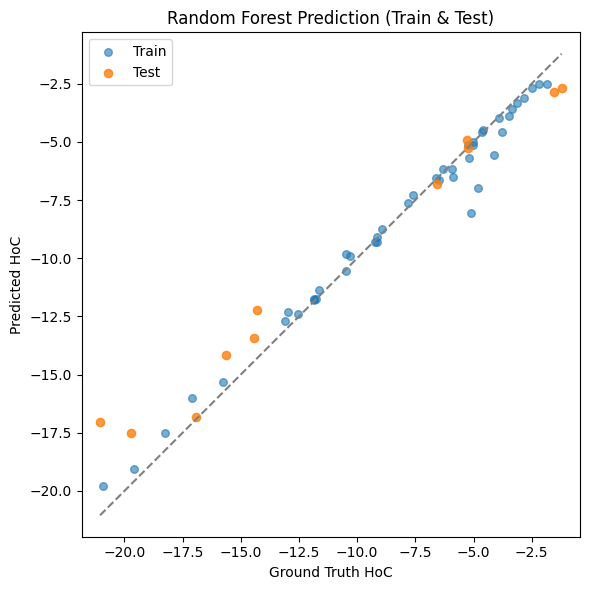

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

# Train
plt.scatter(
    y_train,
    train_pred,
    alpha=0.6,
    s=30,
    label="Train",
)

# Test
plt.scatter(
    y_test,
    test_pred,
    alpha=0.8,
    s=35,
    label="Test",
)

# y = x
min_val = min(y_train.min(), y_test.min())
max_val = max(y_train.max(), y_test.max())

plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    "--",
    color="gray",
)

plt.xlabel("Ground Truth HoC")
plt.ylabel("Predicted HoC")
plt.title("Random Forest Prediction (Train & Test)")
plt.legend()
plt.axis("equal")
plt.tight_layout()
plt.show()
